In [1]:
# %pip install --upgrade pip --user
# %pip install zarr --user
# %pip install tables --user
# %pip install git+https://github.com/simpeg/simpeg.git@simulation-tdem --user
# %pip install dask dask_jobqueue --user
# %pip install git+https://github.com/simpeg-research/casingSimulations.git@simulation --user

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import discretize
from scipy import sparse as sp
from scipy.constants import mu_0
import pandas as pd
from pymatsolver import Pardiso, SolverCG 
import os
import json
import dask
import dask_jobqueue
from dask.distributed import Client

import casingSimulations as casing_sim

import torch

# we are in the midst of upgrading the API, so this is 
# more closely in-line with the upcoming changes
from SimPEG.electromagnetics import time_domain as tdem

%matplotlib inline

In [3]:
Solver = Pardiso
solver_opts = {} #{"maxiter": 10}

In [4]:
data_directory = "./experiment1"
df = pd.read_hdf(f"{data_directory}/trial_data.h5", "data")

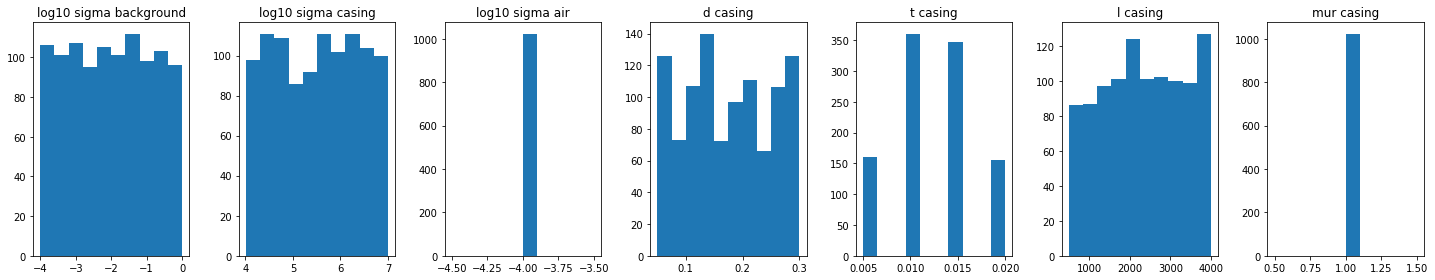

In [5]:
fig, ax = plt.subplots(1,len(df.keys()), figsize=(20, 4))

for i, key in enumerate(df.keys()):
    ax[i].hist(df[key])
    ax[i].set_title(f"{key}".replace("_", " "))

plt.tight_layout()

In [6]:
# pick a single model to try training on 
trial_index = 5  # a 1200 m long well (relatively short --> fast simulations)

trial_directory = f"{data_directory}/trial_{trial_index}"

In [7]:
# generate the 2D model 

with open(f"{trial_directory}/approx_casing.json") as f: 
    params = json.load(f)
model = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)

with open(f"{trial_directory}/simulation_approx_casing.json") as f:
    simulation_params = json.load(f)
    
sim3D = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
mesh3D = sim3D.mesh

In [8]:
# create a 2D simulation
mesh = discretize.CylMesh([mesh3D.hx, 1, mesh3D.hz], x0=mesh3D.x0)
sim = tdem.Problem3D_j(mesh=mesh, time_steps=sim3D.time_steps, solver=Solver, solver_opts=solver_opts, sigma=model.sigma(mesh))


(-2000, 10)

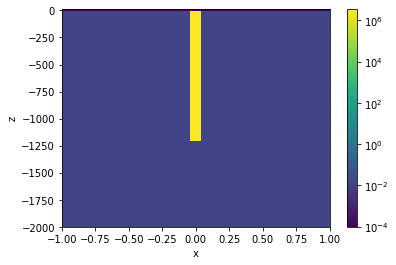

In [9]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    mesh.plotImage(
        sim.sigma, ax=ax, pcolorOpts={"norm":LogNorm()}, mirror=True
    )[0], ax=ax
)
ax.set_xlim([-1, 1])
ax.set_ylim([-2000, 10])

In [10]:
def getRHS(sim, src):
    # full source term 
    # rhs = -1./dt * (s_e - s_en1) + C * MeMuI * s_m

    # we are setting s_e to zero
    rhs = sim.mesh.edgeCurl * (sim.MeMuI * src)
    if sim._makeASymmetric:
        return sim.MfRho.T * rhs
    return rhs

In [11]:
def getRHS_deriv(sim, v=None, adjoint=False):

    # full source term 
    # rhs = -1./dt * (s_e - s_en1) + C * MeMuI * s_m
    # we are setting s_e to zero
    mesh = sim.mesh
    
    if adjoint:
        if sim._makeASymmetric:
            if v is not None: 
                rhs = sim.MfRho * v
            else:
                rhs = sim.MfRho
        else:
            rhs = v if v is not None else sp.eye(mesh.nF)
        return sim.MeMuI.T * (mesh.edgeCurl.T * rhs)
    
    if v is not None:
        rhs = sim.mesh.edgeCurl * (sim.MeMuI * v)
    else:
        rhs = sim.mesh.edgeCurl * sim.MeMuI
    if sim._makeASymmetric:
        return sim.MfRho.T * rhs
    return rhs

In [12]:
# solve the forward problem 
def fields(sim, source):
    f = np.zeros((sim.mesh.nF, sim.nT+1))

    # timestep to solve forward
    Ainv = None
    for tInd, dt in enumerate(sim.timeSteps):
        # keep factors if dt is the same as previous step b/c A will be the
        # same
        if Ainv is not None and (
            tInd > 0 and abs(dt-sim.timeSteps[tInd - 1]) >
            sim.dt_threshold
        ):
            Ainv.clean()
            Ainv = None

        if Ainv is None:
            A = sim.getAdiag(tInd)
            Ainv = Pardiso(A)

        rhs = getRHS(sim, source[:, tInd+1])  # this is on the nodes of the time mesh
        Asubdiag = sim.getAsubdiag(tInd)

        # taking a step
        sol = Ainv * (rhs - Asubdiag * f[:, tInd])
        f[:, tInd+1] = sol

    # clean factors and return
    Ainv.clean()
    return f

In [13]:
def fields_deriv(sim, v=None, adjoint=False):
    
    if adjoint:
        return fields_deriv_adjoint(sim, v=v)
    
    df_dm_v = np.zeros((sim.mesh.nF, sim.nT+1))

    # timestep to solve forward
    Ainv = None
    for tInd, dt in enumerate(sim.timeSteps):
        # keep factors if dt is the same as previous step b/c A will be the
        # same
        if Ainv is not None and (
            tInd > 0 and abs(dt-sim.timeSteps[tInd - 1]) > sim.dt_threshold
        ):
            Ainv.clean()
            Ainv = None
        
        if Ainv is None:
            A = sim.getAdiag(tInd)
            Ainv = Pardiso(A)

        rhs_deriv = getRHS_deriv(sim, v[:, tInd+1])  # this is on the nodes of the time mesh
        Asubdiag = sim.getAsubdiag(tInd)

        # taking a step
        sol = Ainv * (rhs_deriv - Asubdiag * df_dm_v[:, tInd])
        df_dm_v[:, tInd+1] = sol

    # clean factors and return
    Ainv.clean()
    return df_dm_v

In [14]:
def fields_deriv_adjoint(sim, v=None):
    
    df_dmT_v = np.zeros((sim.mesh.nE, sim.nT+1))  # the source is defined on edges

    # timestep to solve forward
    ATinv = None
    for tInd in reversed(range(sim.nT)):
        dt = sim.time_steps[tInd]
        # keep factors if dt is the same as previous step b/c A will be the
        # same
        if ATinv is not None and (
            tInd <= sim.nT and abs(dt-sim.timeSteps[tInd + 1]) > sim.dt_threshold
        ):
            ATinv.clean()
            ATinv = None
        
        if ATinv is None:
            AT = sim.getAdiag(tInd).T
            ATinv = Pardiso(AT)    
        
#         ATinv_v = ATinv * v[:, tInd+1]
        if tInd < sim.nT - 1:
            AsubdiagT = sim.getAsubdiag(tInd+1).T
            sol = ATinv * (v[:, tInd+1] - AsubdiagT * sol)
        else: 
            sol = ATinv * v[:, tInd+1]
        rhs_deriv = getRHS_deriv(sim, sol, adjoint=True)  # this is on the nodes of the time mesh
        
        df_dmT_v[:, tInd+1] = rhs_deriv

    # clean factors and return
    ATinv.clean()
    return df_dmT_v

In [15]:
def create_source(sim, model, s, trial_directory):
    # interpolate on to the spatial mesh (lets use exact time for now)
    z_source = np.load(f"{trial_directory}/z_currents.npy")
    mesh = sim.mesh
    src = np.zeros((mesh.nEy, sim.nT+1))
  
    csx = mesh.hx.min()
    
    xinds = (mesh.gridEy[:, 0] < model.casing_b + csx/2) & (mesh.gridEy[:, 0] > model.casing_b - csx/2)
    zinds = (mesh.gridEy[:, 2] >= model.casing_z.min()) & (mesh.gridEy[:, 2] <= model.casing_z.max())
    src_inds_bool = xinds & zinds
    src_inds = np.where(src_inds_bool)[0]
    
    P = discretize.utils.interpmat(mesh.gridEy[src_inds, 2], z_source)

    src[src_inds, :] = P * s
    
    def grad(dy, adjoint=True):
        if adjoint:
            return P.T * dy[src_inds, :]
        grd = np.zeros((mesh.nEy, sim.nT+1))
        grd[src_inds, :] = P * dy
        return grd
    
    return src, grad
                  

In [16]:
def load_trial(trial_directory):
    # load up the data
    with open(f"{trial_directory}/approx_casing.json") as f: 
        params = json.load(f)
    model = casing_sim.model.CasingInHalfspace.deserialize(params, trusted=True)

    with open(f"{trial_directory}/simulation_approx_casing.json") as f:
        simulation_params = json.load(f)

    sim3D = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    mesh3D = sim3D.mesh
    
    mesh = discretize.CylMesh([mesh3D.hx, 1, mesh3D.hz], x0=mesh3D.x0)
    sim = tdem.Problem3D_j(mesh=mesh, time_steps=sim3D.time_steps, solver=Solver, solver_opts=solver_opts, sigma=model.sigma(mesh))

    return model, mesh, sim

In [17]:
def get_j_interpolation_mat(
    trial_directory, mesh, 
    log10tmin=-6, log10tmax=-2, ntimes=128 # hard-coded from "pipeline_synthetic_data"
):
    xsample = np.load(f"{trial_directory}/x.npy")
    zsample = np.load(f"{trial_directory}/z.npy")
    xz_grid = discretize.utils.ndgrid(xsample, np.r_[0], zsample)
    
    Px = mesh.getInterpolationMat(xz_grid, 'Fx')
    Pz = mesh.getInterpolationMat(xz_grid, 'Fz') 
    
    tsample = np.logspace(log10tmin, log10tmax, ntimes)
    Pt = sim.time_mesh.getInterpolationMat(tsample, 'N')

    # construct full P
    Pxt = sp.kron(Pt, Px)
    Pzt = sp.kron(Pt, Pz)
    P = sp.vstack([Pxt, Pzt])

    return P
    

In [18]:
def run_forward(trial_ind, source_vec):
    trial_directory = f"{data_directory}/trial_{trial_ind}"
    model, mesh, sim = load_trial(trial_directory)
    
    source, source_grad = create_source(sim, model, source_vec, trial_directory)
    f = fields(sim, source)
    P = get_j_interpolation_mat(trial_directory, mesh)
    j_compare = P * discretize.utils.mkvc(f)
    
    def grad(dy, adjoint=True):  
        if adjoint: 
            v = P.T * dy
            v = v.reshape(mesh.nF, sim.nT+1, order="F")
            f_deriv = fields_deriv_adjoint(sim, v)
            return source_grad(f_deriv, adjoint=True)
        f_deriv = fields_deriv(sim, source_grad(dy, adjoint=False))
        return P * discretize.utils.mkvc(f_deriv)
        
    return j_compare, grad

# set up a simple test example 

In [19]:
def waveform(t, t_peak=5e-3, width=10, amplitude=1):
    t = np.log10(t)
    t_peak = np.log10(t_peak)
    width = np.log10(width)
    return amplitude * np.exp(-(t - t_peak)**2/(2*width**2))

def sigmoid(x, x0=0, slope=1):
    return np.arctan(slope * (x-x0))/np.pi + 0.5

def depth_distribution(z, dz=200, slope=1e-1):
    return sigmoid(z, model.casing_z.min() + dz, slope) * sigmoid(-z, -(model.casing_z.max() - dz), slope)

def source_sm(mesh, t, z):
    sm = np.zeros(mesh.nE)
    sm = np.outer(depth_distribution(z), waveform(t))
    
    return sm

In [20]:
z = np.load(f"{trial_directory}/z_currents.npy")
src_vec = source_sm(mesh, sim.times, z)

/usr/common/software/pytorch/v1.2.0-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, 'z')

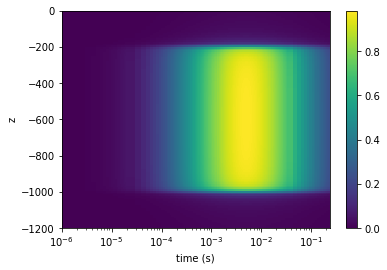

In [21]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ax.pcolormesh(sim.times, z, src_vec), ax=ax)
ax.set_xscale("log")
ax.set_xlim(1e-6, sim.times.max())
ax.set_xlabel("time (s)")
ax.set_ylabel("z")

In [22]:
def test_source(source):   
    source = source.reshape(128, 191, order="F")
    src, grad = create_source(sim, model, source, trial_directory)
    
    def src_deriv(dy, adjoint=False):
        if not adjoint: 
            dy = dy.reshape(128, 191, order="F")
        else:
            dy = dy.reshape(mesh.nE, 191, order="F")
        return discretize.utils.mkvc(grad(dy, adjoint))
    
    return discretize.utils.mkvc(src), src_deriv

x0 = discretize.utils.mkvc(src_vec)
discretize.Tests.checkDerivative(
    test_source,
    x0=x0,
    num=4, 
    plotIt=False, 
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.753e+01     1.127e-14      nan
 1   1.00e-02    1.753e+00     1.043e-14      0.034
 2   1.00e-03    1.753e-01     1.039e-14      0.001
 3   1.00e-04    1.753e-02     1.029e-14      0.004
========================= PASS! =========================
Happy little convergence test!



True

In [23]:
# adjoint test

src_vec = discretize.utils.mkvc(src_vec.reshape(128, 191, order="F"))
src, src_deriv = test_source(src_vec)

v = np.random.rand(128*191)
w = np.random.rand(mesh.nE*191)

a = w.T.dot(discretize.utils.mkvc(src_deriv(v.reshape(128, 191, order="F"), adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(src_deriv(w, adjoint=True)))

print(f"{np.linalg.norm(a):1.3e}, {np.linalg.norm(b):1.3e}, {np.linalg.norm(a-b):1.3e}")

1.149e+04, 1.149e+04, 0.000e+00


In [24]:
def test_rhs(source):   
    source = source.reshape(128, 191, order="F")
    src, grad_src = create_source(sim, model, source, trial_directory)
    rhs = getRHS(sim, src)
    
    def src_deriv(dy, adjoint=False):
        if not adjoint:
            dy = dy.reshape(128, 191, order="F")
            return discretize.utils.mkvc(getRHS_deriv(sim, grad_src(dy, adjoint), adjoint))
        else: 
            dy = dy.reshape(mesh.nF, 191, order="F")
            return grad_src(getRHS_deriv(sim, dy, adjoint), adjoint)        
    
    return discretize.utils.mkvc(rhs), src_deriv

x0 = discretize.utils.mkvc(src_vec)
discretize.Tests.checkDerivative(
    test_rhs,
    x0=x0,
#     dx=1e-3*x0,
    num=4, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.379e+12     2.793e-04      nan
 1   1.00e-02    1.379e+11     1.839e-04      0.181
 2   1.00e-03    1.379e+10     1.840e-04      -0.000
 3   1.00e-04    1.379e+09     1.819e-04      0.005
*********************************************************
<<<<<<<<<<<<<<<<<<<<<<<<< FAIL! >>>>>>>>>>>>>>>>>>>>>>>>>
*********************************************************
Did you put your clever trousers on today?



False

In [25]:
# adjoint test

src_vec = discretize.utils.mkvc(src_vec.reshape(128, 191, order="F"))
rhs, rhs_deriv = test_rhs(src_vec)

v = np.random.rand(128*191)
w = np.random.rand(mesh.nF*191)

a = w.T.dot(discretize.utils.mkvc(rhs_deriv(v.reshape(128, 191, order="F"), adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(rhs_deriv(w, adjoint=True)))

print(f"{np.linalg.norm(a):1.3e}, {np.linalg.norm(b):1.3e}, {np.linalg.norm(a-b):1.3e}")

1.169e+14, 1.169e+14, 1.094e-01


In [26]:
src_sm, _ = create_source(sim, model, src_vec.reshape(128, 191, order="F"), trial_directory)

def test_forward(src_sm):
    src_sm = src_sm.reshape(mesh.nEy, sim.nT+1, order="F")
    j = fields(sim, src_sm)
    
    def j_deriv(v, adjoint=False):
        if not adjoint:
            v = v.reshape(mesh.nEy, sim.nT+1, order="F")
            return discretize.utils.mkvc(fields_deriv(sim, v, adjoint))
        else:
            v = v.reshape(mesh.nF, sim.nT+1, order="F")
            return fields_deriv(sim, v, adjoint)
    return discretize.utils.mkvc(j), j_deriv

x0 = discretize.utils.mkvc(src_sm)
discretize.Tests.checkDerivative(
    test_forward,
    x0=x0,
    num=4, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------


/global/homes/l/lheagy/.local/cori/pytorchv1.2.0-gpu/lib/python3.6/site-packages/SimPEG/simulation.py:479: UserWarning: timeSteps will be depreciated in favor of time_steps. Please update your code accordingly
  "timeSteps will be depreciated in favor of time_steps. "


 0   1.00e-01    3.836e+08     2.227e-03      nan
 1   1.00e-02    3.836e+07     1.672e-03      0.125
 2   1.00e-03    3.836e+06     1.485e-03      0.052
 3   1.00e-04    3.836e+05     1.500e-03      -0.004
*********************************************************
<<<<<<<<<<<<<<<<<<<<<<<<< FAIL! >>>>>>>>>>>>>>>>>>>>>>>>>
*********************************************************
LHEAGY ERROR!



False

In [27]:
# adjoint test

j, j_deriv = test_forward(src_sm)

v = np.random.rand(np.prod(src_sm.shape))
w = np.random.rand(np.prod(j.shape))

a = w.T.dot(discretize.utils.mkvc(j_deriv(v, adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(j_deriv(w, adjoint=True)))

print(f"{np.linalg.norm(a):1.3e}, {np.linalg.norm(b):1.3e}, {np.linalg.norm(a-b):1.3e}")

7.380e+11, 7.380e+11, 7.255e-01


In [28]:
def test_forward_full(src_vec):
    src_vec = src_vec.reshape(128, 191, order="F")
    j, j_deriv = run_forward(5, src_vec)
    
    def grad(v):
        v = v.reshape(128, 191, order="F")
        return discretize.utils.mkvc(j_deriv(v, adjoint=False))
    return discretize.utils.mkvc(j), grad

x0 = discretize.utils.mkvc(src_vec)
discretize.Tests.checkDerivative(
    test_forward_full,
    x0=x0,
    num=5, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.818e-02     6.789e-12      nan
 1   1.00e-02    1.818e-03     4.393e-12      0.189
 2   1.00e-03    1.818e-04     1.065e-11      -0.384
 3   1.00e-04    1.818e-05     2.491e-11      -0.369
 4   1.00e-05    1.818e-06     2.970e-11      -0.076
========================= PASS! =========================
Once upon a time, a happy little test passed.



True

In [29]:
# adjoint test

src_vec = src_vec.reshape(128, 191, order="F")
j, j_deriv = run_forward(5, src_vec)

v = np.random.rand(128*191)
w = np.random.rand(np.prod(j.shape))

a = w.T.dot(discretize.utils.mkvc(j_deriv(v.reshape(128, 191, order="F"), adjoint=False)))
b = v.T.dot(discretize.utils.mkvc(j_deriv(w, adjoint=True)))

err = a-b
if np.linalg.norm(err)/np.linalg.norm(a) < 1e-10:
    passing = True
else: 
    passing = False
    
print(
    f"{np.linalg.norm(a):1.3e}, "
    f"{np.linalg.norm(b):1.3e}, "
    f"{np.linalg.norm(err):1.3e}, "
    f"{'passing :)' if passing is True else 'failing :('}"
)

6.684e+00, 6.684e+00, 4.056e-11, passing :)


In [30]:
def test_sanity_check(src_vec):
#     src_vec = src_vec.reshape(128, 2, order="F")
    A = np.random.randn(128, 128)
    bigA = sp.block_diag([A, A])
    j = bigA.dot(src_vec)
    
    def grad(v):
#         v = v.reshape(128, 2, order="F")
        return discretize.utils.mkvc(bigA.dot(v))
    return discretize.utils.mkvc(j), grad

x0 = discretize.utils.mkvc(src_vec[:, 0:2])
discretize.Tests.checkDerivative(
    test_sanity_check,
    x0=x0,
    num=10, 
    plotIt=False, 
    expectedOrder=1,
)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.834e+01     2.449e+01      nan
 1   1.00e-02    1.773e+00     2.433e+00      1.003
 2   1.00e-03    2.488e-01     2.895e-01      0.925
 3   1.00e-04    1.630e-01     1.641e-01      0.247
 4   1.00e-05    1.682e-01     1.682e-01      -0.011
 5   1.00e-06    1.533e-01     1.533e-01      0.040
 6   1.00e-07    1.638e-01     1.638e-01      -0.029
 7   1.00e-08    1.604e-01     1.604e-01      0.009
 8   1.00e-09    1.498e-01     1.498e-01      0.030
 9   1.00e-10    1.565e-01     1.565e-01      -0.019
*********************************************************
<<<<<<<<<<<<<<<<<<<<<<<<< FAIL! >>>>>>>>>>>>>>>>>>>>>>>>>
*********************************************************
LHEAGY ERROR!



False

In [31]:
src_sm, _ = create_source(sim, model, src_vec, trial_directory)
src_sm = src_sm.reshape(mesh.nEy, sim.nT+1, order="F")
j = fields(sim, src_sm)

Text(0.5, 1.0, 'current density, t=1.2e-01ms')

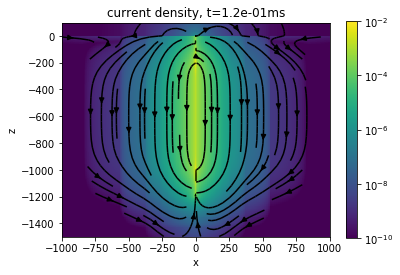

In [32]:
tind = 30
fig, ax = plt.subplots(1, 1)

out = mesh.plotImage(
    mesh.aveF2CCV * j[:, tind], 
    view="vec",
    vType="CCv",
    ax=ax, mirror=True,
    range_x=np.r_[-1000, 1000], 
    range_y=np.r_[-1500, 100],
    sample_grid = np.r_[5., 5.],
    pcolorOpts={"norm":LogNorm()},
    clim = np.r_[1e-10, 1e-2], 
    stream_threshold = 1e-10
)
ax.set_aspect(1)
plt.colorbar(out[0])

ax.set_title(f"current density, t={sim.times[tind]*1e3:1.1e}ms")

Text(0.5, 1.0, 'source term, t=1.0e-02ms')

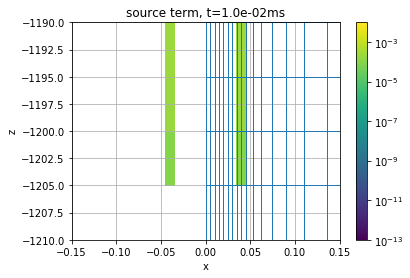

In [33]:
tind = 10
fig, ax = plt.subplots(1, 1)

out = mesh.plotImage(
    mesh.aveE2CC * src_sm[:, tind], 
#     view="vec",
#     vType="CCv",
    ax=ax, mirror=True,
    range_x=0.15*np.r_[-1, 1], 
    range_y=np.r_[-1210, -1190], #10*np.r_[-1, 1],
#     sample_grid = np.r_[5., 5.],
    pcolorOpts={"norm":LogNorm()},
    clim = np.r_[1e-13, 1e-2], 
#     stream_threshold = 1e-13
)
mesh.plotGrid(ax=ax)
# ax.set_aspect(1)
plt.colorbar(out[0])

ax.set_title(f"source term, t={sim.times[tind]*1e3:1.1e}ms")

# Set up ML pipeline

In [74]:
dtype = torch.float32
device = torch.device("cpu")

In [34]:
nspatial = 128
ntimes = 191
nsrcz = 128

In [218]:
class ForwardSimulation(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, source_vec): #, trial_ind):
#         trial_ind = tri
        trial_directory = f"{data_directory}/trial_{trial_ind}"
        
        # load up objects 
        model, mesh, sim = load_trial(trial_directory)
        
        ctx.model = model
        ctx.mesh = mesh
        ctx.sim = sim

        # create source 
        source, source_grad = create_source(sim, model, source_vec.data.numpy(), trial_directory)
        rhs = getRHS(sim, source)
        
        ctx.source_grad = source_grad
        
        # compute fields 
        f = fields(sim, source)
        
        if getattr(ctx, 'P', None) is None:
            P = get_j_interpolation_mat(trial_directory, mesh)
            ctx.P = P
        
        # project data
        j_compare = (P * discretize.utils.mkvc(f))
        
        if dtype == torch.float32:
            return torch.from_numpy(j_compare).float()
        return torch.from_numpy(j_compare).double()

    @staticmethod
    def backward(ctx, dy): 
        P = ctx.P
        v = P.T * dy.data.numpy()
        v = v.reshape(ctx.mesh.nF, ctx.sim.nT+1, order="F")
        f_deriv = fields_deriv_adjoint(ctx.sim, v)
        grad = ctx.source_grad(f_deriv, adjoint=True)

        if dtype == torch.float32:
            return torch.from_numpy(grad).float()
        return torch.from_numpy(grad).double()



In [219]:
# class CasingData(torch.utils.data.Dataset):
#     def __init__(self, directory, trial_indices):
#         self.directory = directory
#         self.trial_indices = trial_indices
        
#     def __len__(self):
#         return len(self.trial_indices)
    
#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        
        
        

In [220]:
# source, source_deriv = create_source(sim, model, src_vec, trial_directory)
# rhs = getRHS(sim, source)

trial_ind = 10
trials = [trial_ind]

jd_numpy = np.load(f"{trial_directory}/j_difference.npy")

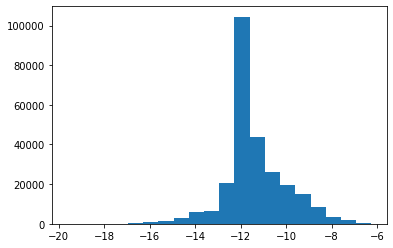

In [221]:
plt.hist(np.log10(np.abs(jd_numpy)), 20);

In [281]:
floor = 1e-10
print((np.abs(jd_numpy)>floor).sum() / len(jd_numpy))

0.1580657958984375


In [380]:
jd = torch.from_numpy(jd_numpy)

std = 0.05 
w = torch.from_numpy(1./(std * np.abs(jd_numpy) + floor))

forward = ForwardSimulation.apply

if dtype == torch.float64:
    jd = jd.double()
    w = w.double() 
else:
    jd = jd.float()
    w = w.float()
    
s0_scaling = 1e-5
learning_rate = 20

# optimizer = torch.optim.SGD(s0, lr=learning_rate)

In [384]:
def convert_to_torch_sparse(mat):
    mat = mat.tocoo()
    
    values = mat.data
    indices = np.vstack((mat.row, mat.col))

    # create pytorch sparse matrix
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = mat.shape
    
    mat_torch = torch.sparse.FloatTensor(i, v, torch.Size(shape))

In [385]:
Dtime = discretize.utils.sdiag(1./sim.time_mesh.hx) * discretize.utils.ddx(sim.nT)
Dtime_torch = convert_to_torch_sparse(Dtime)

z_currents = np.load(f"{trial_directory}/z_currents.npy")
Dz = discretize.utils.sdiag(1./np.diff(z_currents)) * discretize.utils.ddx(len(z_currents)-1)
Dz_torch = convert_to_torch_sparse(Dz)

In [386]:
# %%time
max_iter = 20
beta = None
beta_factor = 2

alpha_s = 1e-4
alpha_t = sim.time_mesh.hx.min()**2
alpha_z = 1

s0 = torch.zeros(nspatial, ntimes, dtype=dtype, device=device, requires_grad=True)

if beta is None:
    s0_tmp = torch.randn(nspatial, ntimes, dtype=dtype, device=device, requires_grad=True)
    j_pred = forward(s0_scaling * s0_tmp)
    dmisfit = 1./len(jd)*(w*(j_pred - jd)).pow(2).sum()
    regularization = (
        alpha_s * s0_tmp.pow(2).sum() + 
        alpha_t * Dtime_torch.mm(s0_tmp.T).pow(2).sum() + 
        alpha_z * Dz_torch.mm(s0_tmp).pow(2).sum()
    )
    beta = beta_factor * dmisfit.item() / regularization.item()

for i in range(max_iter):
    s_iter = s0_scaling * s0
    j_pred = forward(s_iter)
    dmisfit = 1./len(jd)*(w*(j_pred - jd)).pow(2).sum()
    smallness = alpha_s * s0.pow(2).sum()
    smooth_time = alpha_t *Dtime_torch.mm(s0.T).pow(2).sum()
    smooth_depth = alpha_z * Dz_torch.mm(s0).pow(2).sum()
    
    regularization = (
        smallness + 
        smooth_time + 
        smooth_depth
    )
    
    loss = dmisfit + beta * regularization
    print(
        f"iter {i}, "
        f"dmisfit: {dmisfit.item():1.4e}, "
        f"reg: {regularization.item():1.4e}, "
        f"beta * reg: {beta * regularization.item():1.4e}, "
        f"loss: {loss.item():1.4e}"
    )
    
    print(
        f"    small: {smallness.item():1.4e}, "
        f"smooth time: {smooth_time.item():1.4e}, "
        f"smooth depth: {smooth_depth.item():1.4e}\n"
    )
    
#     optimizer.zero_grad()
    loss.backward()
#     optimizer.step()
    with torch.no_grad():
        s0 -= learning_rate * s0.grad
        s0.grad.zero_()

SyntaxError: invalid syntax (<ipython-input-386-7e6e4bcbe10f>, line 8)

Text(0, 0.5, 'z')

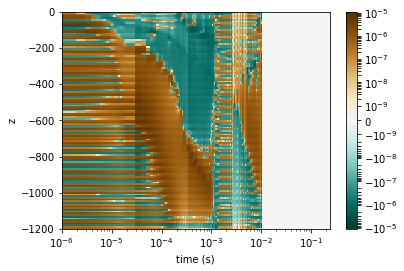

In [375]:
fig, ax = plt.subplots(1, 1)

z = np.load(f"{trial_directory}/z_currents.npy")
plotme = s0_scaling * s0.data.numpy()
clim = np.r_[1e-4, 1] * np.max(np.abs(plotme))
norm = SymLogNorm(
        clim[0] if clim is not None else
        np.max([1e-20, np.min(np.absolute(plotme))]),
        vmin = -clim[1], vmax=clim[1]
    )
    
plt.colorbar(ax.pcolormesh(sim.times, z, plotme, cmap="BrBG_r", norm=norm), ax=ax)
ax.set_xscale("log")
ax.set_xlim(1e-6, sim.times.max())
ax.set_xlabel("time (s)")
ax.set_ylabel("z")

In [358]:
# load up objects 
model, mesh, sim = load_trial(trial_directory)
src, _ = create_source(sim, model, s0.data.numpy(), trial_directory)

(-2000, 50)

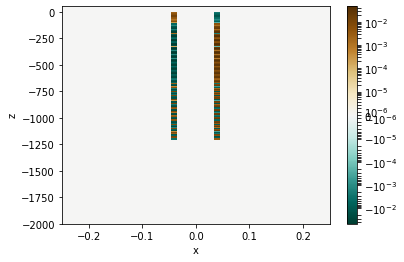

In [368]:
tind = 10
plotme = mesh.aveE2CC * src[:, tind]

clim = np.r_[1e-4, 1] * np.max(np.abs(plotme))
norm = SymLogNorm(
        clim[0] if clim is not None else
        np.max([1e-20, np.min(np.absolute(plotme))]),
        vmin = -clim[1], vmax=clim[1]
    )

fig, ax = plt.subplots(1, 1)
plt.colorbar(mesh.plotImage(
    plotme, 
    mirror=True, 
    mirror_data=-1*plotme,
    pcolorOpts={"norm": norm, "cmap": "BrBG_r"},
    ax=ax
)[0], ax=ax)

ax.set_xlim(0.25*np.r_[-1, 1])
ax.set_ylim(np.r_[-2000, 50])

In [355]:
x = np.load(f"{trial_directory}/x.npy")
z = np.load(f"{trial_directory}/z.npy")
t = np.logspace(-6, -2, 128)

nj = len(x) * len(z)

/usr/common/software/pytorch/v1.2.0-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


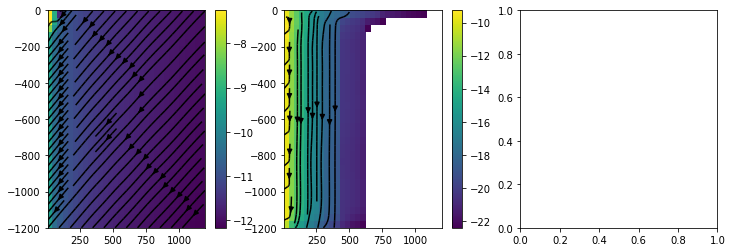

In [356]:
tind = 20

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
j_plot = j_pred.data.numpy()
jx = j_plot[:nj*len(t)].reshape(len(x)*len(z), len(t), order="F")[:, tind]
jz = j_plot[nj*len(t):].reshape(len(x)*len(z), len(t), order="F")[:, tind]

jx = jx.reshape(len(x), len(z), order="F")
jz = jz.reshape(len(x), len(z), order="F")
j_amplitude = np.sqrt(jx**2 + jz**2)

jtrue_x = jd_numpy[:nj*len(t)].reshape(len(x)*len(z), len(t), order="F")[:, tind]
jtrue_z = jd_numpy[nj*len(t):].reshape(len(x)*len(z), len(t), order="F")[:, tind]
jtrue_x = jtrue_x.reshape(len(x), len(z), order="F")
jtrue_z = jtrue_z.reshape(len(x), len(z), order="F")
jtrue_amplitude = np.sqrt(jtrue_x**2 + jtrue_z**2)

# plot the true
plt.colorbar(ax[0].pcolormesh(x, z, np.log10(jtrue_amplitude).T), ax=ax[0])
ax[0].streamplot(x, z, jtrue_x.T, jtrue_z.T, color="k")

# plot the estimated
plt.colorbar(ax[1].pcolormesh(x, z, np.log10(j_amplitude).T), ax=ax[1])
ax[1].streamplot(x, z, jx.T, jz.T, color="k")

# plot the difference

Text(0.5, 1.0, 'current density, t=2.0e-02ms')

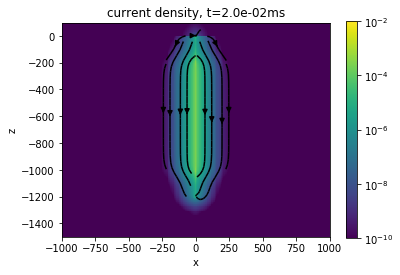

In [357]:
fig, ax = plt.subplots(1, 1)

out = mesh.plotImage(
    mesh.aveF2CCV * j[:, tind], 
    view="vec",
    vType="CCv",
    ax=ax, mirror=True,
    range_x=np.r_[-1000, 1000], 
    range_y=np.r_[-1500, 100],
    sample_grid = np.r_[5., 5.],
    pcolorOpts={"norm":LogNorm()},
    clim = np.r_[1e-10, 1e-2], 
    stream_threshold = 1e-10
)
ax.set_aspect(1)
plt.colorbar(out[0])

ax.set_title(f"current density, t={sim.times[tind]*1e3:1.1e}ms")

In [ ]:
class CasingNet(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional component (for currents in casing)
        self.conv1 = 
        
        # dense component (for parameters of casing model)
        
        # combine the two 
        
    def forward(self, x):
        
        pass
        